# Finite-difference approximations

Suppose that we are given some function $f(x)$, mapping real inputs $x$ to real outputs $f(y)$, but **all we can do is evaluate it** for any given $x$.  For example, suppose that $f(x)$ is calculated by some complicated compute program whose *internals we cannot easily analyze*.

This is called a "black box" function, and there are lots of real-world settings where one might want to perform various analyses of such functions: integration ("quadrature"), optimization, root-finding, and more.  One common task is **numerical differentiation**:

* How can we **estimate** the **derivative** $f'(x)$ given *only* the ability to evaluate $f(x)$ with *finite accuracy* (to a finite number of significant digits)?

It turns out that finite-difference approximations are a surprisingly complicated subject, with rich connections to many areas of numerical analysis (from uncertainy quantification to solving differential equations); in this lecture we will just scratch the surface.

* *Remark*: There is also a rich subject of how to accurately and efficiently compute *exact* derivatives of computer programs, limited only by roundoff errors: [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).  See also [18.063: Matrix Calculus](https://ocw.mit.edu/courses/18-s096-matrix-calculus-for-machine-learning-and-beyond-january-iap-2023/) at MIT.

# Finite-difference approximations: Easy version

The simplest way to estimate a derivative is to recall that the definition:
$$
f'(x) = \lim_{\delta x \to 0} \frac{f(x+\delta x) - f(x)}{\delta x}
$$
So, we can just compare the **finite difference**
$$
f'(x) \approx \; \boxed{ \frac{f(x+\delta x) - f(x)}{\delta x} } + \text{(higher-order corrections)} \, ,
$$
for some **tiny but *not* infinitesimal δx > 0**.  This also called a **forward difference** approximation (for $\delta x > 0$).  We'll look at other possibilities below.

* The antonym of a forward diffence is a **backward difference** approximation $f'(x) \approx [f(x) - f(x - \delta x)] / \delta x$, but this equivalent to just flipping the sign of $\delta x$. … If you only want to compute a derivative, there is usually not much practical distinction between forward and backward differences.  The difference becomes more important when discretizing (approximating) differential equations.

## example: f(x)=sin(x)

Let's try it for $f(x) = \sin(x)$, where of course we already know that the exact answer is $f'(x) = \cos(x)$.

Now, let's apply a finite difference at some point, say $x = 1$, with a small $\delta x = 10^{-8}$:

In [1]:
x = 1
δx = 1e-8 # a small perturbation 10⁻⁸

@show exact = cos(x) # exact derivative
@show approx = (sin(x+δx) - sin(x))/δx # forward difference approximation

# difference:
@show abs(approx - exact)

exact = cos(x) = 0.5403023058681398
approx = (sin(x + δx) - sin(x)) / δx = 0.5403023028982545
abs(approx - exact) = 2.9698852266335507e-9


2.9698852266335507e-9

To be more quantitative, we computed the "difference" $|\text{approx} - \text{exact}|$, which we want to be small.   But small **compared to what?**   The natural answer is **small compared to the correct answer**.  This is called the [relative error](https://en.wikipedia.org/wiki/Approximation_error) (or "fractional" error):
$$
\text{relative error} = \frac{| \text{approx} - \text{exact} |}{| \text{exact} |}
$$
More generally, we will later be computing approximations that are *vectors* (including elements of general [vector spaces](https://en.wikipedia.org/wiki/Vector_space), like matrices and functions!) and not just scalars, so we can generalize this by replacing the absolute value $| \cdots |$ with a [norm](https://en.wikipedia.org/wiki/Norm_(mathematics)) $\Vert \cdots \Vert$ (like the familiar Euclidean length of a column vector):
$$
\text{relative error} = \frac{\Vert \text{approx} - \text{exact} \Vert}{\Vert \text{exact}\Vert}
$$
For a scalar, the norm is just the absolute value.

In Julia, the `LinearAlgebra` package provides a `norm` function, and we can use that to define a relative error.

In [2]:
using LinearAlgebra

relative_error(approx, exact) = norm(approx - exact) / norm(exact)

relative_error (generic function with 1 method)

Let's try it on our case above:

In [3]:
relative_error(approx, exact)

5.496710257161753e-9

Pretty good — we are matching to **about eight significant digits**!

Getting a good match for a arbitrary input and an arbitrary small displacement isn't a proof of correctness, but it is always a good thing to check.   This kind of randomized comparison will almost always **catch major bugs** where you have calculated the exact derivative incorrectly, for example:

# Accuracy of finite differences

How accurate is our finite-difference approximation above?  How should we choose the size of δx?

Let's try our example $f(x) = \sin x$ above, and plot the relative error at $x=1$ as a function of $\Vert \delta x \Vert$:

In [4]:
using Plots # load a plotting package; there are several to choose from in Julia; this is a popular one
using LaTeXStrings # makes it easy to put LaTeX equations in L"..." strings

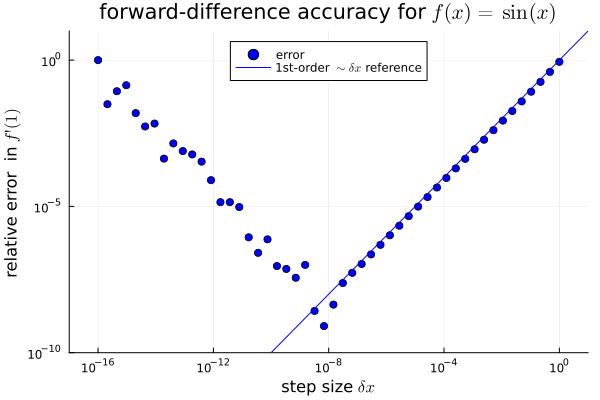

In [5]:
δx = 10 .^ range(-16,0,50) # 50 points from 10⁻¹⁶ to 10⁰
errors = @. relative_error( (sin(x+δx) - sin(x))/δx , cos(1) )

scatter(δx, errors, xaxis=:log, yaxis=:log, markershape=:circle,markercolor=:blue,
     title = L"forward-difference accuracy for $f(x)=\sin(x)$", xlabel=L"step size $\delta x$", ylabel=L"relative error  in $f'(1)$",
     label = "error", xticks = [1, 10^-4, 10^-8, 10^-12, 10^-16], xlim=[10^-17, 10^1], ylim = [10^-10, 10^1], legend=:top)

plot!(10 .^ range(-10,8,50), 10 .^ range(-10,8,50), linecolor=:blue, label=L"1st-order $ \sim \delta x$ reference")


We observe two main features:

* The relative error initially decreases *linearly* with $\Vert \delta x \Vert$.  This is called **first-order accuracy**.  Why?
* When δx gets too small, the error *increases*.  Why?

## Truncation error: Order of accuracy

If the relative error scales with $\Vert \delta x \Vert^n$, we call the approximation **n-th order accurate**.  For forward differences, here, the order is **n=1**.  Why?

For any $f(x)$ with a nonzero second derivative (think of the Taylor series), we have
$$
    f(x + \delta x) = f(x) + f'(x) \delta x + \underbrace{(\text{terms proportional to } \delta x ^2) +  (\text{higher-order})}_{O(\delta x^2)}
$$

But if we plug this into our finite-difference approximation, it means that the **error is roughly linear in δx**:
$$
\begin{align}
  f'(x) &\approx \frac{ f(x+\delta x) - f(x)}{\delta x} = \frac{ \cancel{f(x)} + f'(x)\cancel{\delta x} + O(\delta x^\cancel{2}) - \cancel{f(x)}}{\cancel{\delta x}} \\
   &= f'(x) + \underbrace{O(\delta x)}_\text{error}
\end{align}
$$

This source of error in a finite-difference approximation, due to **inherent** error in the formula for **non-infinitesimal** $\delta x$, is called **truncation error**.

## Roundoff error: Catastrophic cancellation

The reason why the error *increased* for very small $\delta x$ was due to **roundoff errors**.  The computer only stores a **finite number of significant digits** (about 15 decimal digits by default) for each real number and rounds off the rest on each operation — this is called [floating-point arithmetic](https://en.wikipedia.org/wiki/Floating-point_arithmetic), and we will spend more time on it soon.

If δx is too small, then the difference $f(x+\delta x) - f(x)$ gets rounded off to zero (some or all of the *significant digits cancel*).  This is called [catastrophic cancellation](https://en.wikipedia.org/wiki/Catastrophic_cancellation).

Let's look more closely at our finite-difference approximation with $\delta x = 10^{-8}$.  If we compute $\sin(1 + \delta x)$ and $\sin(1)$ to about 16 digits, what do we get?

In [6]:
δx = 1e-8

@show sin(1 + δx)
@show sin(1)

sin(1 + δx) = 0.8414709902109195
sin(1) = 0.8414709848078965


0.8414709848078965

In [7]:
8414709902109195 - 8414709848078965 # subtract the decimal parts

54030230

Now we are subtracting them:
$$
\sin(1+10^{-8}) - \sin(1) \approx \mathbf{0.8414709}902109195 - \underbrace{\mathbf{0.8414709}}_\text{7 digits cancel}848078965 \\
\approx \mathbf{0.0000000}\underbrace{54030230}_\text{7 digits left}
$$

So, even if we *started* with 16 significant digits, *half* of the accurate digits are **cancelling**. 

The **final result** is only accurate to 6–7 digits!!  This is an example of the phenomenon known as ["catastrophic cancellation"](https://en.wikipedia.org/wiki/Catastrophic_cancellation).

Now let's make $\delta x$ much smaller, $\delta x = 10^{-100}$:

In [8]:
dx = 1e-100
(sin(1 + dx) - sin(1))/dx

0.0

What happened?   The computer can represent small numbers just fine, because floating-point corresponds to "scientific notation":

In [9]:
1e-100

1.0e-100

But look at this:

In [10]:
1 + 1e-100

1.0

The correct answer would be
$$
1 + 10^{-100} = 1.\underbrace{000000\cdots000000}_{\text{99 zeros}}1
$$
but the computer only stores about 15 decimal digits (by default … you can ask for more, at the expense of speed), so it rounds this to $1.0$.

Hence, our finite difference gave zero.

Even if we do something less extreme, we have problems.   This looks okay:

In [11]:
dx = 1e-13
1 + dx

1.0000000000001

because the computer has enough digits, right?  But compare:

In [12]:
sin(1 + dx)

0.8414709848079505

In [13]:
sin(1)

0.8414709848078965

They only differ in the **last 4 significant digits stored**.  So when you subtract them, you only have **4 digits** left:

In [14]:
relative_error((sin(1 + dx) - sin(1))/dx, cos(1))

0.001358343083756518

and the error for $\delta x = 10^{-13}$ is now $10^{-3}$!!

## Higher-order finite-difference approximations

Of course, there are other finite-difference formulas.  For example, the most famous is the **centered-difference** formula:

$$
f'(x) \approx \frac{f(x+\delta x) - f(x - \delta x)}{2\,\delta x} + O(\delta x ^2)
$$

This formula is **second-order accurate**: the error in the derivative is proportional to $ \delta x^2$ (assuming a thrice-differentiable function).   You can show this by plugging the Taylor series for $f(x\pm \delta x)$ into the difference formula above, keeping up to the *second*-derivative term in the Taylor series:
$$
f(x\pm\delta x) = f(x)  \pm f'(x)\delta x  + \frac{1}{2} f''(x) \delta x^2 \pm O(\delta x^3) \, ,
$$
which gives
\begin{multline}
\frac{f(x+\delta x) - f(x - \delta x)}{2\,\delta x} \\
= \frac{\left[ \cancel{f(x)} + f'(x)\delta x  + \cancel{\frac{1}{2} f''(x) \delta x^2} + O(\delta x^3) \right] - \left[ \cancel{f(x)} - f'(x)\delta x  + \cancel{\frac{1}{2} f''(x) \delta x^2} - O(\delta x^3) \right])}{2\,\delta x} \\
= \frac{\cancel{2} f'(x)\cancel{\delta x} + O(\delta x^\cancelto{2}{3}))}{\cancel{2\,\delta x}}
= f'(x) + O(\delta x^2) \, .
\end{multline}

We can try it for $\sin(x)$ at $x=1$ as above:

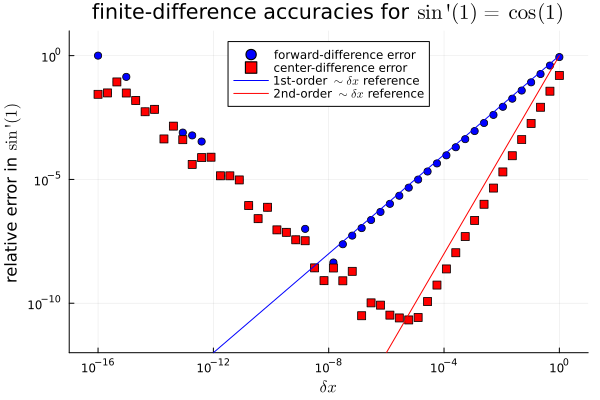

In [15]:
s = 10 .^ range(-16,0,50)
errors = [relative_error((sin(1+s)-sin(1))/s, cos(1)) for s in s]
scatter(s, errors, xaxis=:log, yaxis=:log, markershape=:circle, markercolor=:blue,
     title = L"finite-difference accuracies for $\sin'(1) = \cos(1)$", xlabel=L"\delta x", ylabel=L"relative error in $\sin'(1)$",
     xticks = [1, 10^-4, 10^-8, 10^-12, 10^-16], xlim=[10^-17, 10^1], ylim = [10^-12, 10^1], legend=:top,
     label = "forward-difference error")

errors2 = [relative_error((sin(1+s)-sin(1-s))/2s, cos(1)) for s in s]
scatter!(s, errors2, xaxis=:log, yaxis=:log, markershape=:square, markercolor=:red,
     label = "center-difference error")
plot!(s, s, linecolor=:blue, label=L"1st-order $\sim  \delta x $ reference")
plot!(s, s.^2, linecolor=:red, label=L"2nd-order $\sim \delta x $ reference")

Indeed, the error goes down proportional to $\delta x^2$ in the center-difference case, until it too is limited by roundoff errors.

### Even higher order:

One can go even further than this:

* You can derive higher-order finite-difference "stencil" formulas whose truncation error goes down even faster, at the expense of more function evaluations.   A simple four-line function to generate finite-difference stencils in Julia is given below (a much more complicated algorithm, probably unnecessarily complicated, is given in [Fornberg, 1988](https://www.ams.org/journals/mcom/1988-51-184/S0025-5718-1988-0935077-0/S0025-5718-1988-0935077-0.pdf)). It defineds a function `stencil`, which takes a vector $x$ of $n$ points $x[i]$ and returns a vector of weights $w[i]$ to compute the $m$-th derivative ($m < n$) of a function at given $x_0$ (usually $x_0 = 0$) at a maximum order ($\ge n - m$) of accuracy, via the formula $f^{(m)}(x_0) \approx \sum_i w[i] f(x[i])$:

```jl
function stencil(x::AbstractVector{<:Real}, x₀::Real, m::Integer)
    ℓ = 0:length(x)-1
    m in ℓ || throw(ArgumentError("order $m ∉ $ℓ"))
    A = @. (x' - x₀)^ℓ / factorial(ℓ)
    return A \ (ℓ .== m) # vector of weights w
end
```

Given this stencil, we can then compute $f^{(m)}(y)$ at any point $y + h x_0$, with a step size scaled by $h$, via $f^{(m)}(y + h x_0) \approx \frac{1}{h^m} \sum_i w[i] f(y+hx[i])$.   So, for example, we will get the ordinary centered-difference approximation from `stencil([-1,0,1], 0//1, 1)`, which returns weights $[-1/2, 0, +1/2]$.

### Adaptive high-order extrapolation:

One of the most sophisticated black-box finite-difference strategies is to **adaptively extrapolate** to $\delta x \to 0$:

* You can evaluate the finite-difference approximation for smaller and smaller $\delta x$, fit to polynomials of higher and higher degree in $\delta x$, and *extrapolate* to $\delta x \to 0$.  You can even do this *adaptively* in order to determine when to stop shrinking $\delta x$ because roundoff errors are dominating, by monitoring the difference between successive extrapolations.
* A sophisticated version of this process is called [Richardson extrapolation](https://github.com/JuliaMath/Richardson.jl), and a classic description of it for numerical differentiation can be found in [Ridder (1982)](https://www.sciencedirect.com/science/article/abs/pii/S0141119582800570).

The [Julia FiniteDifferences.jl package](https://github.com/JuliaDiff/FiniteDifferences.jl) provides a large number of these techniques (both higher-order formulas and Richardson extrapolation techniques).

## Finite differences in higher dimensions

Higher-dimensional *inputs* $x$ pose a fundamental computational challenge for finite-difference techniques, because if you want to know what happens for **every possible direction δx** then we need **many finite differences** — one for **each dimension of δx**.

For example, suppose $x \in \mathbb{R}^n$ ($n$-component column vector) and $f(x)$ is a scalar.  Then $\nabla f$ has **n components** $\partial f/\partial x_k$, and if you want to know the *whole gradient* then you need **n finite differences**.

Generally, you need one finite difference for "each column" of the Jacobian (i.e. each input dimension).  (If there is a single scalar output, then the Jacobian is $\nabla f^T$.)

The net result is that **finite differences in higher dimensions are expensive**: you have to evaluate $f(x)$ around $\sim n$ times in $n$ input dimensions.   This makes finite differences **impractical** for high-dimensional optimization (e.g. neural networks) where $n$ might be thousands or millions or (even billions).   

On the other hand, if you are just using finite differences as a *check*, it is usually sufficient to compute $\nabla f^T \delta x \approx f(x+\delta x) - f(x)$ in a few **random directions**, i.e. for random small *vectors* $\delta x$.  This is a [directional derivative](https://en.wikipedia.org/wiki/Directional_derivative).